# Step 1: Setup & Install

In [1]:
!pip install xgboost
!pip install scikit-learn
!pip install tensorflow


# Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Step 3: Upload and Load the Dataset

In [3]:
from google.colab import files
uploaded = files.upload()


Saving predictive_maintenance.csv to predictive_maintenance.csv


In [4]:
import io

# Automatically pick the uploaded file
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Preview the data
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Step 4: Data Preprocessing

In [5]:
# Drop irrelevant columns
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

# Encode the 'Type' column
df['Type'] = LabelEncoder().fit_transform(df['Type'])

# Drop 'Failure Type' column since we're focusing on binary failure prediction
df.drop(['Failure Type'], axis=1, inplace=True)

# Separate features and target
X = df.drop('Target', axis=1)
y = df['Target']

# Normalize features using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)


# Step 5: Logistic Regression

In [8]:
from sklearn.metrics import accuracy_score

# Train Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print("Logistic Regression Results")
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
Accuracy Score: 0.966
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1932
           1       0.00      0.00      0.00        68

    accuracy                           0.97      2000
   macro avg       0.48      0.50      0.49      2000
weighted avg       0.93      0.97      0.95      2000



# Step 6: Random Forest Classifier

In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest Results")
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results
Accuracy Score: 0.9845
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.65      0.74        68

    accuracy                           0.98      2000
   macro avg       0.93      0.82      0.87      2000
weighted avg       0.98      0.98      0.98      2000



# Step 7: XGBoost Classifier

In [11]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("XGBoost Results")
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Results
Accuracy Score: 0.9875
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.72      0.80        68

    accuracy                           0.99      2000
   macro avg       0.94      0.86      0.90      2000
weighted avg       0.99      0.99      0.99      2000



# Step 8: LSTM (Neural Network)

In [12]:
# Reshape input for LSTM: (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train model
model.fit(X_train_lstm, y_train,
          validation_data=(X_test_lstm, y_test),
          epochs=10, batch_size=64,
          callbacks=[early_stop], verbose=1)

# Predict
y_pred_lstm = (model.predict(X_test_lstm) > 0.5).astype("int32")

# Evaluate
print("LSTM Results")
print("Accuracy Score:", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9123 - loss: 0.5386 - val_accuracy: 0.9660 - val_loss: 0.1906
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9671 - loss: 0.1743 - val_accuracy: 0.9660 - val_loss: 0.1672
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9664 - loss: 0.1637 - val_accuracy: 0.9660 - val_loss: 0.1650
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9708 - loss: 0.1453 - val_accuracy: 0.9660 - val_loss: 0.1628
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9674 - loss: 0.1544 - val_accuracy: 0.9660 - val_loss: 0.1605
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9653 - loss: 0.1645 - val_accuracy: 0.9660 - val_loss: 0.1583
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9658 - loss: 0.1593 - val_accuracy: 0.9660 - val_loss: 0.1562
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9635 - loss: 0.1642 - val_accuracy: 0.

# Step 9: Confusion Matrix for All Models

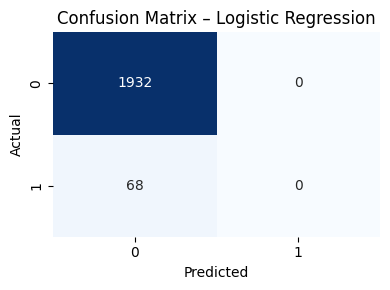

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix – {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression")



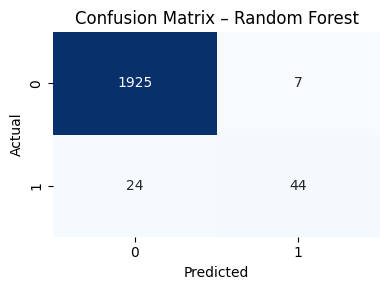

In [15]:
plot_conf_matrix(y_test, y_pred_rf, "Random Forest")


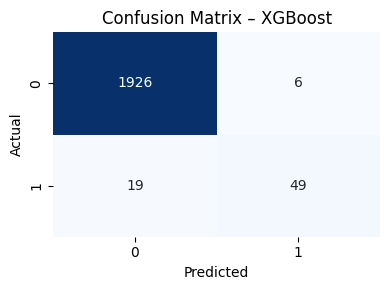

In [16]:
plot_conf_matrix(y_test, y_pred_xgb, "XGBoost")


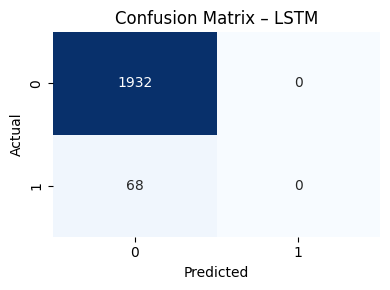

In [17]:
plot_conf_matrix(y_test, y_pred_lstm, "LSTM")

# Step 10: Plot ROC Curves

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


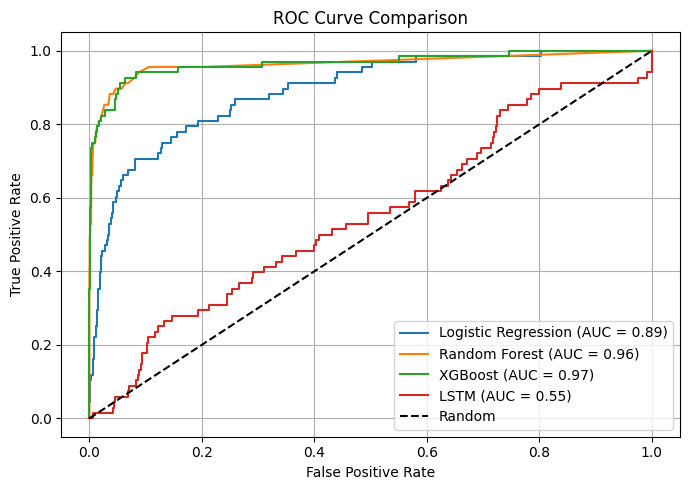

In [19]:
from sklearn.metrics import roc_curve, auc

def plot_roc(model_name, y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(7, 5))

# Logistic Regression
y_proba_lr = lr.predict_proba(X_test)[:, 1]
plot_roc("Logistic Regression", y_test, y_proba_lr)

# Random Forest
y_proba_rf = rf.predict_proba(X_test)[:, 1]
plot_roc("Random Forest", y_test, y_proba_rf)

# XGBoost
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
plot_roc("XGBoost", y_test, y_proba_xgb)

# LSTM (convert probs from sigmoid)
y_proba_lstm = model.predict(X_test_lstm).ravel()
plot_roc("LSTM", y_test, y_proba_lstm)

# Finalize plot
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 11: XGBoost Feature Importance

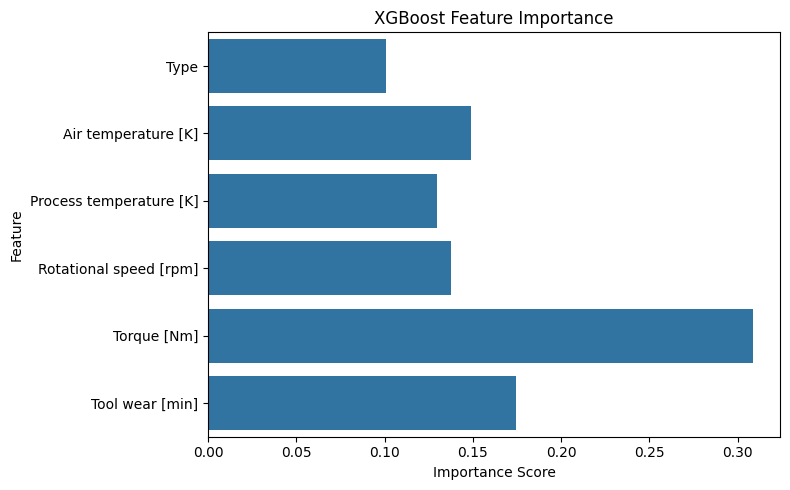

In [20]:
importances = xgb.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Step 12 :Model Comparison – Accuracy vs Recall vs F1 Score

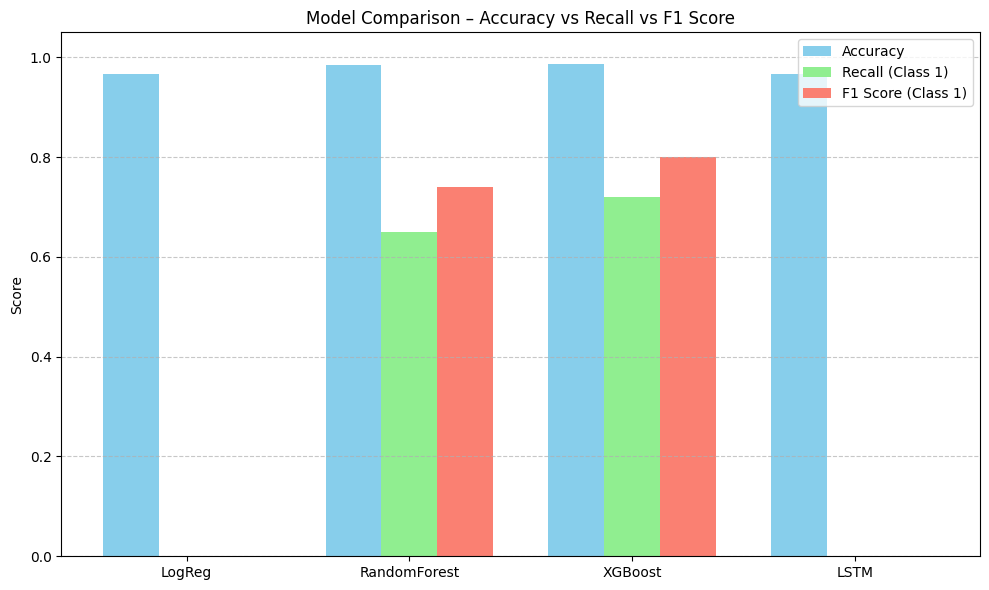

In [21]:
import numpy as np

# Metrics for each model (based on earlier outputs)
models = ['LogReg', 'RandomForest', 'XGBoost', 'LSTM']

accuracies = [0.966, 0.9845, 0.9875, 0.966]
recalls     = [0.00, 0.65, 0.72, 0.00]
f1_scores   = [0.00, 0.74, 0.80, 0.00]

x = np.arange(len(models))  # label locations
width = 0.25

plt.figure(figsize=(10, 6))

# Accuracy bars
plt.bar(x - width, accuracies, width, label='Accuracy', color='skyblue')

# Recall bars
plt.bar(x, recalls, width, label='Recall (Class 1)', color='lightgreen')

# F1 Score bars
plt.bar(x + width, f1_scores, width, label='F1 Score (Class 1)', color='salmon')

# Labels and legend
plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Comparison – Accuracy vs Recall vs F1 Score')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
